# Import library

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import random

# from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, MaxPooling2D, Flatten, BatchNormalization, Conv2D, Dropout, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

## Dictionary of all classes

In [2]:
sign_names = {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
    }


## Create paths

In [3]:
# Create paths to Train & Test data
data_path = './data'
train_path = './data/Train'
test_path = './data/Test'
num_labels = len(os.listdir(train_path))

## Hyperparameter

In [4]:
width = 30
height = 30
channel = 3

lr = 0.001
epoch = 30
batch_size = 32

# Visualization

## Number pictures of each class

<AxesSubplot:xlabel='Sign_Name', ylabel='Frequency'>

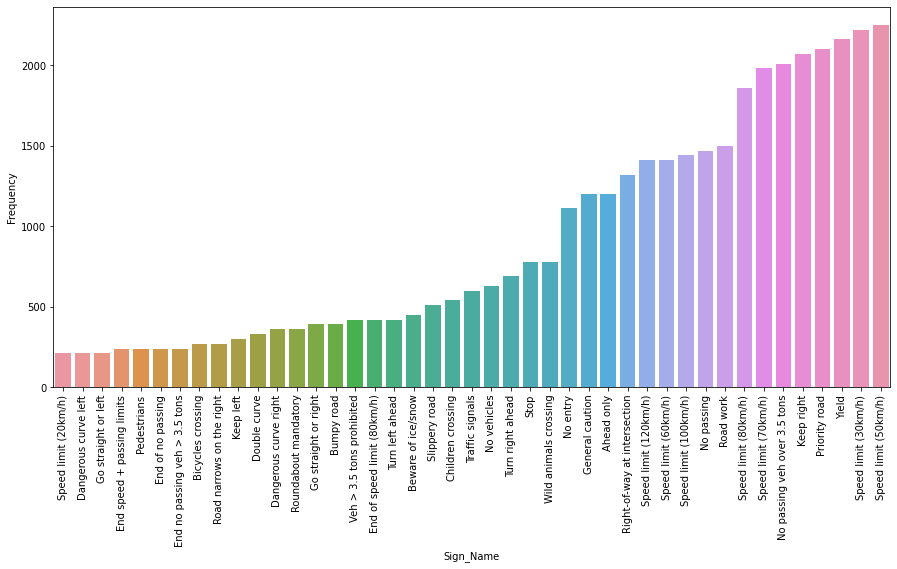

In [5]:
# Count number of pictures in each class
num_train = []
sign = []
for folder in os.listdir(train_path):
    num_train.append(len(os.listdir(os.path.join(train_path, folder))))
    sign.append(sign_names[int(folder)])
    
# Plot Barchart the present frequency of each class
a = pd.DataFrame(data=num_train, columns=['Frequency'])
b = pd.DataFrame(data=sign, columns=['Sign_Name'])
table = pd.concat((b,a), axis=1).sort_values(by='Frequency').reset_index().drop(columns='index')

plt.figure(figsize=(15,7))
plt.xticks(rotation=90)
sns.barplot(data=table, x='Sign_Name', y='Frequency')

We can see that the dataset's labels are not evenly distributed. Number of labels is between 250 and 2300

## Show random pictures of each class

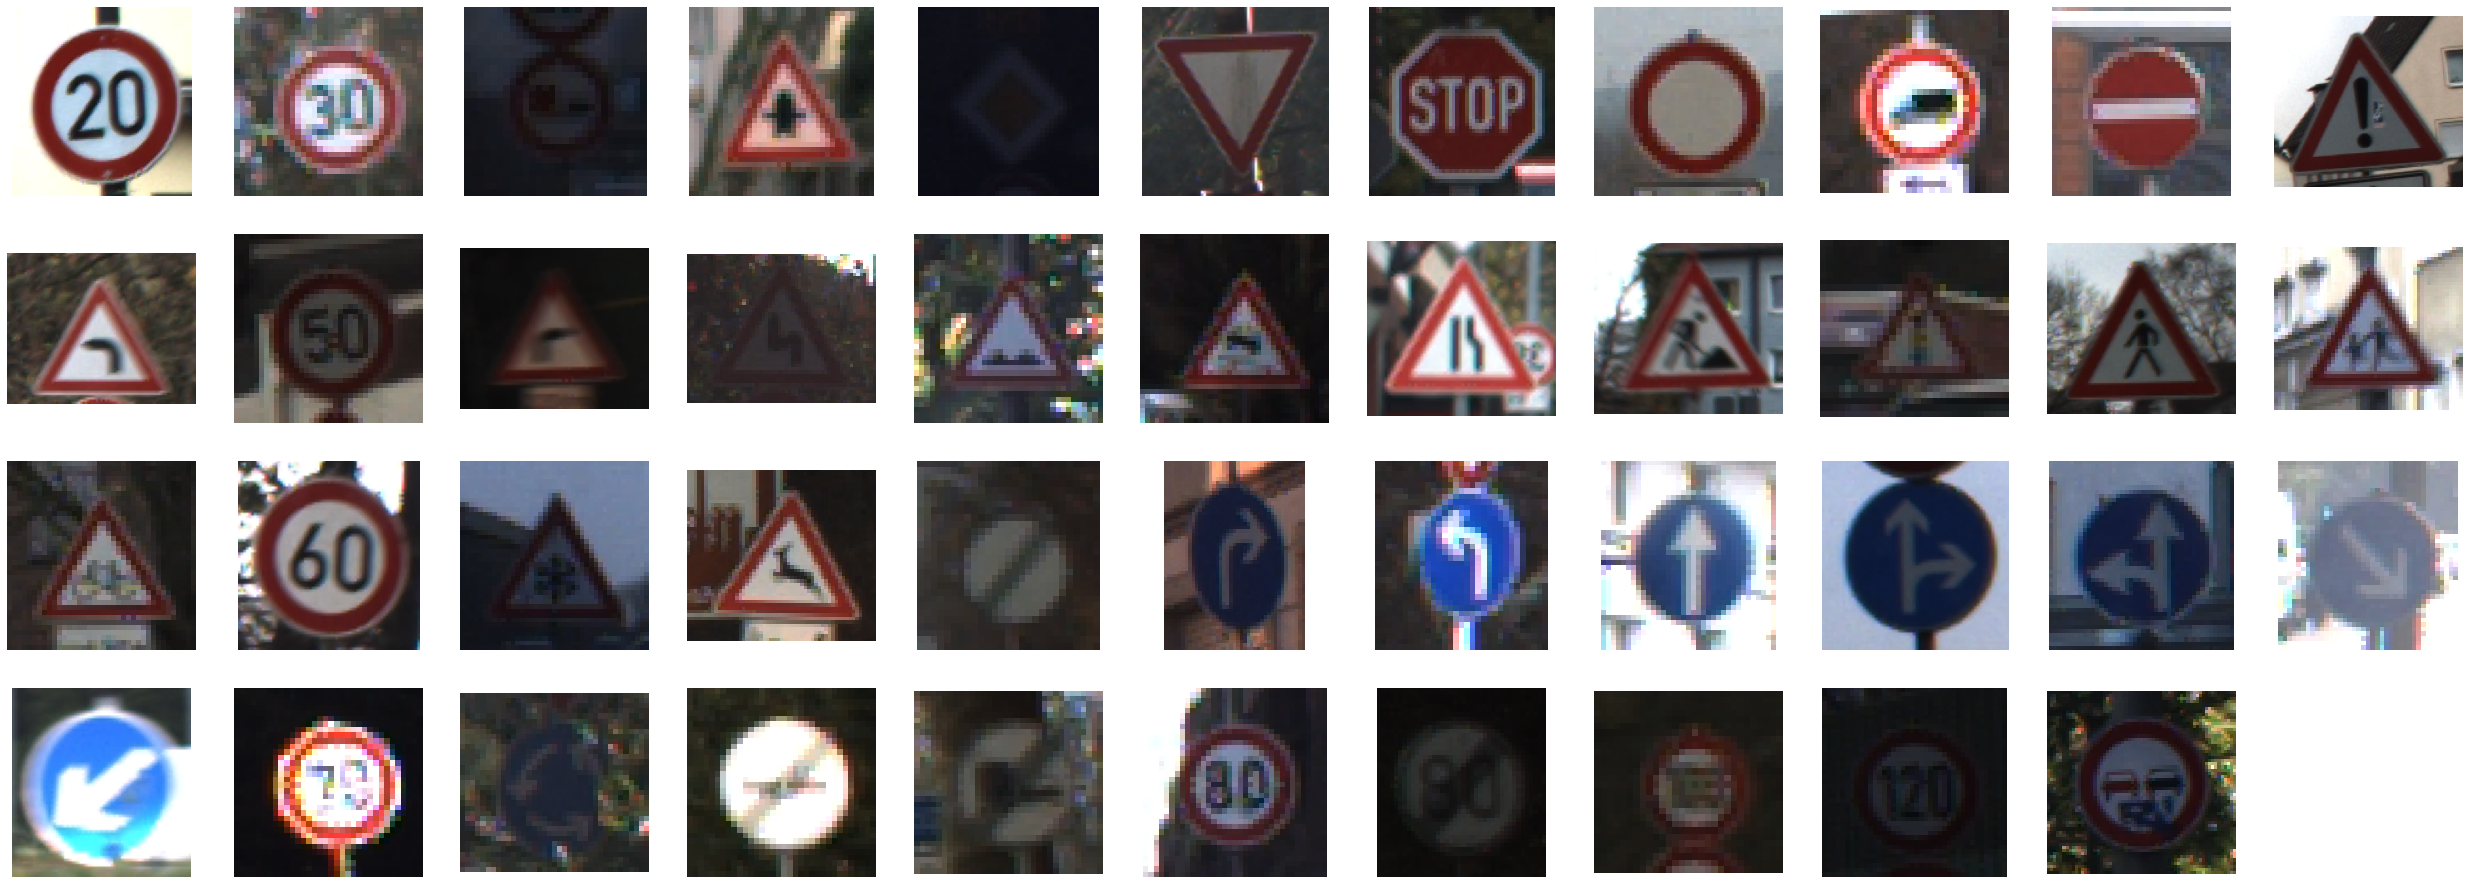

In [6]:
# Show random pictures
nrows = 4
ncols = 11
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
folder_list = os.listdir(train_path)
pic_list = []
for folder in folder_list:
    pic = random.sample(os.listdir(os.path.join(train_path, folder)), 1)[0]
    pic_list.append(os.path.join(train_path, folder, pic))
for i in range(len(pic_list)):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(pic_list[i])
  plt.imshow(img)

plt.show()

# Preprocessing

## Get all data (resize to 30x30)

Get all data from each folder in Train directory. Because size of pictures is not same as each others. So we want to resize all the picture into a same size (30x30).

In [7]:
def load_data(path):
    pictures = []
    labels = []
    for folder in folder_list:
        folder_path = os.path.join(path, folder)
        for pic in os.listdir(folder_path):
            picture = load_img(os.path.join(folder_path, pic), target_size=(width,height)) # resize to 30x30
            picture = img_to_array(picture)
            pictures.append(picture)
            labels.append(folder)
    # Change train data to np.array
    return np.array(pictures), labels

## Shuffle and split data into Train and Validation

We do not have validation set yet, so we need to create one. But first, we need to shuffle all the data from train set (we use **np.random.seed(42)** and **random_state** when split to keep validation set unchange each time we run this code => easy for us to finetune our model)

We also use **to_categorical** to one-hot encode our labels when total number of classes is 43.

In [8]:
pictures, labels = load_data(train_path)
# one-hot encode labels (43 classes)
labels = to_categorical(labels)

# Add np.random.seed
np.random.seed(42)
indexes = np.arange(pictures.shape[0])
np.random.shuffle(indexes)
pictures = pictures[indexes]
labels = labels[indexes]
# Split data into Train and Validation
X_train, X_val, y_train, y_val = train_test_split(pictures, labels, test_size=0.2, random_state=42)

## Get test data, resize to 30x30 & normalize
Test label and path informations is summarized in a CSV file. Base on that, we create test data and its labels.

We also want to **rescale** our test data into range 0-1.

In [9]:
test_csv = pd.read_csv(data_path + '/Test.csv')
test_csv.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [10]:
# Get test data form csv file (label and path informations)
test_csv = pd.read_csv(data_path + '/Test.csv')

y_test = to_categorical(test_csv["ClassId"].values)
test_pictures = test_csv["Path"].values

test =[]

for pic in test_pictures:
    picture = load_img(os.path.join(data_path, pic), target_size=(width,height)) # Resize into 30x30
    picture = img_to_array(picture)
    test.append(picture)
X_test = np.array(test)
# Rescale
X_test = X_test/255

Print shapes of Train, Test, Validation set for final check.

In [11]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(31367, 30, 30, 3)
(12630, 30, 30, 3)
(7842, 30, 30, 3)
(31367, 43)
(12630, 43)
(7842, 43)


## ImageDataGenerator on Train and Validation set

We use **ImageDataGenerator** to augmentate our data => help model have good accuracy on prediction and prevent our model become overfitting.
We also rescale Train and Validation data into range 0-1.

First, I set higher parameters (0.2) but the difference between Loss of train set and Loss of test set is huge, so I reduce every into 0.1.

In [12]:
def generator_augmentation_maker():
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            fill_mode='nearest')
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(
            X_train, y_train,
            batch_size=batch_size)

    validation_generator = test_datagen.flow(
            X_val, y_val,
            batch_size=batch_size)
    return train_generator, validation_generator

# MODELLING

## Create Model

In [16]:
def model_maker():
    model = Sequential([

        Conv2D(16, (3,3), activation='relu', input_shape=(width,height,channel)),
        # BatchNormalization(),
        # MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(32, (3,3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3,3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3,3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),

        Dense(43, activation='softmax'),
    ])
    return model

model = model_maker()
model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 11, 11, 64)       

## Early Stopping

We want to avoid overfitting, so EarlyStopping() is a good choice for our model.

In [17]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    # Stop training when `val_loss` is no longer improving
    monitor='val_loss',
    # "no longer improving" being defined as "no better than 1e-2 less"
    min_delta=1e-2,
    # "no longer improving" being further defined as "for at least 5 epochs", 
    patience=5,
    verbose=1)

We save the model (not only weights) base on the best val_loss result.

In [18]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="./Checkpoint/my_model_checkpoint_{epoch}.h5",
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 verbose=1)

## Train model

In [19]:
train_generator, validation_generator = generator_augmentation_maker()
history = model.fit(
      train_generator,
      epochs=epoch,
      validation_data=validation_generator,
      verbose=2, callbacks=[checkpoint_callback, earlystopping_callback])

Epoch 1/30
981/981 - 19s - loss: 1.0918 - accuracy: 0.6789 - val_loss: 0.1986 - val_accuracy: 0.9331

Epoch 00001: val_loss improved from inf to 0.19861, saving model to ./Checkpoint\my_model_checkpoint_1.h5
Epoch 2/30
981/981 - 13s - loss: 0.2567 - accuracy: 0.9196 - val_loss: 0.1044 - val_accuracy: 0.9657

Epoch 00002: val_loss improved from 0.19861 to 0.10440, saving model to ./Checkpoint\my_model_checkpoint_2.h5
Epoch 3/30
981/981 - 14s - loss: 0.1656 - accuracy: 0.9481 - val_loss: 0.1000 - val_accuracy: 0.9660

Epoch 00003: val_loss improved from 0.10440 to 0.10002, saving model to ./Checkpoint\my_model_checkpoint_3.h5
Epoch 4/30
981/981 - 14s - loss: 0.1361 - accuracy: 0.9568 - val_loss: 0.0965 - val_accuracy: 0.9708

Epoch 00004: val_loss improved from 0.10002 to 0.09651, saving model to ./Checkpoint\my_model_checkpoint_4.h5
Epoch 5/30
981/981 - 13s - loss: 0.1084 - accuracy: 0.9669 - val_loss: 0.0505 - val_accuracy: 0.9811

Epoch 00005: val_loss improved from 0.09651 to 0.05049

## Plot result

We got good result with accuracy of train set is 98.66% and accuracy of validation set is 99.67%.

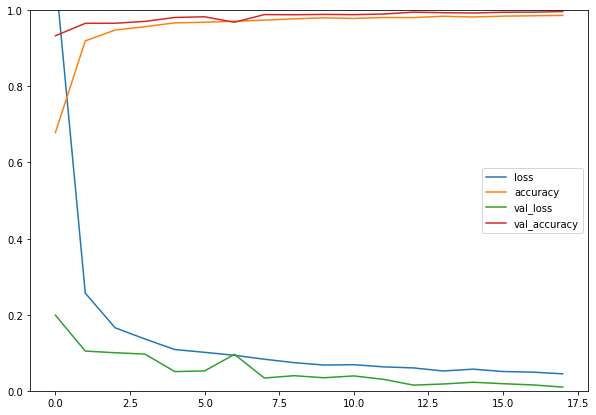

In [20]:
pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.ylim(0, 1)
plt.show()

I tried alot of model and save the best model into another folder, and I can load this model to use later.

In [21]:
restored_model = tf.keras.models.load_model('./Checkpoint/my_model_checkpoint_18.h5')
restored_model.summary()
restored_model.compile(optimizer=Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

# Re-evaluate the model
loss, acc = restored_model.evaluate(validation_generator)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 11, 11, 64)       

In [22]:
restored_model.evaluate(X_test, y_test)

395/395 [==============================] - 2s 4ms/step - loss: 0.1213 - accuracy: 0.9748


[0.12128829956054688, 0.9748218655586243]

Result of the best model is really good with 99.67% accuracy on Validation set and 97.48% on test set

# Evaluate model

 ## Confusion Matrix

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

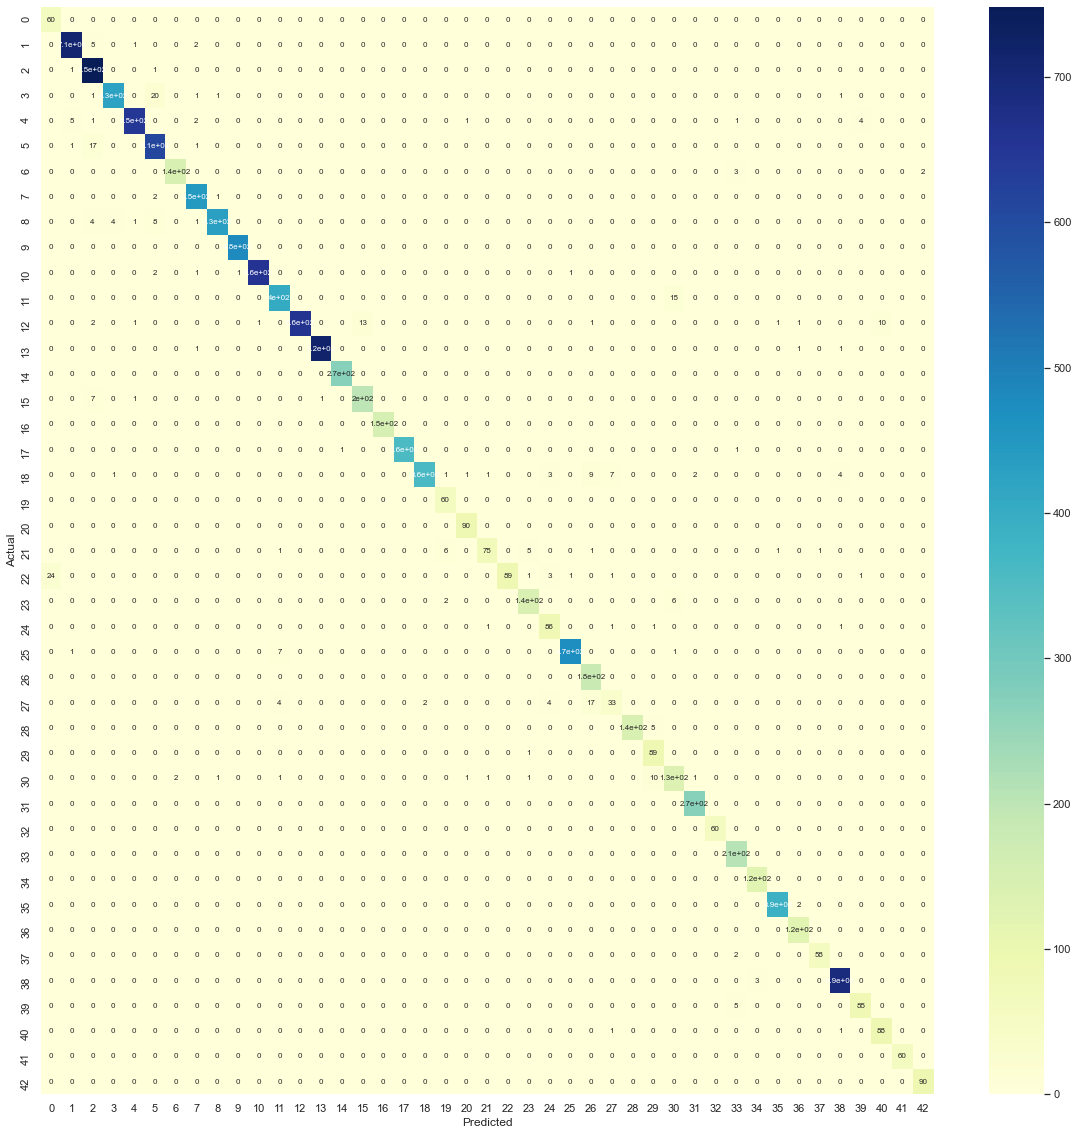

In [23]:
predictions = np.argmax(restored_model.predict(X_test), axis=-1)
y_labels = test_csv["ClassId"].values
data = confusion_matrix(y_labels, predictions)
df_cm = pd.DataFrame(data, columns=np.unique(range(43)), 
                     index = np.unique(range(43)))

df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,20))
sns.set(font_scale=1)
sns.heatmap(df_cm, cmap="YlGnBu", annot=True,annot_kws={"size": 8})

Each pair (labels and predicts) of pictures have most number of incorrect prediction

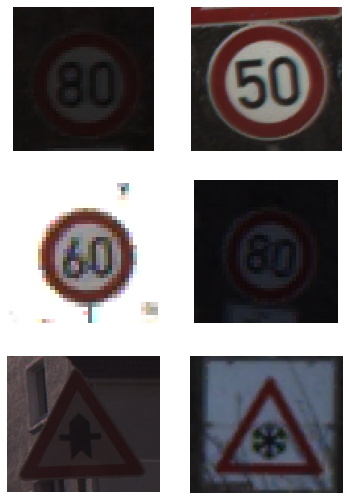

In [25]:
folder_list = [5, 2, 3, 5, 11, 30]
nrows = 3
ncols = 2
fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)
pic_list_test = []
for folder in folder_list:
    pic = random.sample(os.listdir(os.path.join(train_path, str(folder))), 1)[0]
    pic_list_test.append(os.path.join(train_path, str(folder), pic))
for i in range(len(pic_list_test)):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(pic_list_test[i])
  plt.imshow(img)

plt.show()

## Classification Report

In [26]:
print(classification_report(y_labels, predictions))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        60
           1       0.99      0.99      0.99       720
           2       0.95      1.00      0.97       750
           3       0.99      0.95      0.97       450
           4       0.99      0.98      0.99       660
           5       0.95      0.97      0.96       630
           6       0.99      0.97      0.98       150
           7       0.98      0.99      0.99       450
           8       0.99      0.96      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      0.99      1.00       660
          11       0.97      0.96      0.97       420
          12       1.00      0.96      0.98       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.94      0.96      0.95       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Samples of Incorrect predictions on test set

In [27]:
def plot_images(images, labels):
    '''Plot images with their labels. Ten each row'''
    plt.figure(figsize=(20, 10))
    columns = 10
    for i, image in enumerate(images):
        ax = plt.subplot(int(len(images) / columns + 1), int(columns), int(i + 1))
        ax.set_title(f"{sign_names[labels[i][0]]}", fontsize=11)
        plt.axis('off')
        plt.subplots_adjust(bottom=0.1)
        plt.imshow(image, cmap='gray')

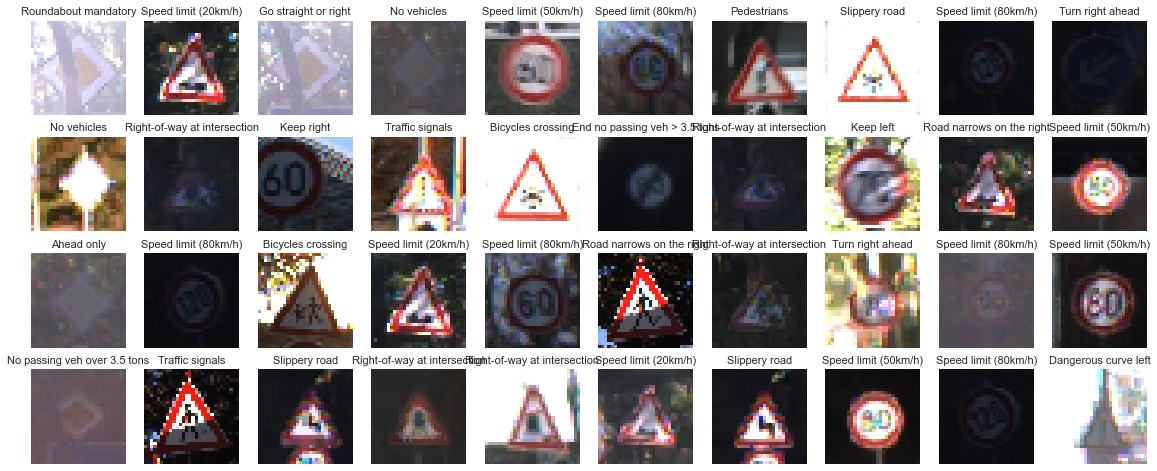

In [28]:
result = pd.DataFrame(y_labels, columns=['Labels'])
result1 = pd.DataFrame(predictions, columns=['Predictions'])
total = pd.concat((result, result1), axis=1)
index = total[total['Labels'] != total['Predictions']].sample(40).index
img = X_test[index, :, :]
predict = result1.loc[index].values
plot_images(img, predict)

# Running the Model (Predict a real image)

In [29]:
import traitlets
from ipywidgets import widgets
from IPython.display import display
from tkinter import Tk, filedialog


class SelectFilesButton(widgets.Button):
    """A file widget that leverages tkinter.filedialog."""

    def __init__(self):
        super(SelectFilesButton, self).__init__()
        # Add the selected_files trait
        self.add_traits(files=traitlets.traitlets.List())
        # Create the button.
        self.description = "Select Files"
        self.icon = "square-o"
        self.style.button_color = "orange"
        # Set on click behavior.
        self.on_click(self.select_files)

    @staticmethod
    def select_files(b):
        """Generate instance of tkinter.filedialog.

        Parameters
        ----------
        b : obj:
            An instance of ipywidgets.widgets.Button 
        """
        # Create Tk root
        root = Tk()
        # Hide the main window
        root.withdraw()
        # Raise the root to the top of all windows.
        root.call('wm', 'attributes', '.', '-topmost', True)
        # List of selected fileswill be set to b.value
        b.files = filedialog.askopenfilename(multiple=True)

        b.description = "Files Selected"
        b.icon = "check-square-o"
        b.style.button_color = "lightgreen"
my_button = SelectFilesButton()
my_button # This will display the button in the context of Jupyter Notebook

SelectFilesButton(description='Select Files', icon='square-o', style=ButtonStyle(button_color='orange'))

In [30]:
for path in my_button.files:
    img=load_img(path, target_size=(30, 30))

    x=img_to_array(img)
    x=np.expand_dims(x, axis=0)

    classes = model.predict(x, batch_size=10)

    print(f'{os.path.basename(path)} is {sign_names[np.argmax(classes[0])]}')